In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import xarray as xr
# from matplotlib.axes import Axes
# from cartopy.mpl.geoaxes import GeoAxes
import pickle

###
from parcels import Variable, FieldSet, ParticleSet, AdvectionRK4, JITParticle
from parcels import ErrorCode, DiffusionUniformKh, Field, plotTrajectoriesFile
from datetime import timedelta
import datetime

INFO: Compiled ParcelsRandom ==> /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/libparcels_random_b63aea27-3611-4c25-9e1f-a9a52c4aa8af.so


In [3]:
river_sources = np.load('../river_sources.npy', allow_pickle=True).item()

In [4]:
river_sources

{'Luanda': (-9.3, 13.0),
 'Cuvo': (-10.87917, 13.7),
 'Paraiba': (-21.6208, -40.9),
 'Itajai': (-26.9125, -48.5),
 'Chiloango-Congo': (-5.6442, 12.05),
 'Cape-Town': (-33.93, 18.2),
 'Rio-de-la-Plata': (-34.8, -57.2),
 'Rio-de-Janeiro': (-23.1, -43.32083),
 'Porto-Alegre': (-32.15, -51.9),
 'Santos': (-24.15, -46.2958)}

In [5]:
coastal_cells = np.load('../coastal_cells.npy')

In [6]:
smoc = xr.open_dataset('../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc')

In [7]:
indices = {'lat': range(1, 900), 'lon': range(1284, 2460)}

In [8]:
y = smoc['latitude'][indices['lat']]
x = smoc['longitude'][indices['lon']]

<xarray.DataArray 'so' (latitude: 899, longitude: 1176)>
[1057224 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -73.0 -72.92 -72.83 ... 24.75 24.83 24.92
  * latitude   (latitude) float32 -79.92 -79.83 -79.75 ... -5.25 -5.167 -5.083
    depth      float32 0.494
    time       datetime64[ns] 2018-01-01T12:00:00
Attributes:
    long_name:      Salinity
    standard_name:  sea_water_salinity
    units:          1e-3
    unit_long:      Practical Salinity Unit
    valid_min:      2
    valid_max:      29044
    cell_methods:   area: mean

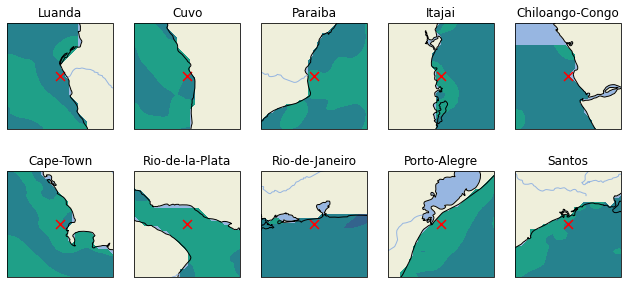

In [29]:
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(11,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})
r = 1
i = 0

ax = ax.reshape(10)
smoc_field = smoc['uo'][0,0,indices['lat'], indices['lon']]
for k, loc in enumerate(river_sources):
    lat_BA, lon_BA = river_sources[loc]
    ax[k].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[k].add_feature(cfeature.OCEAN)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].add_feature(cfeature.RIVERS)
    ax[k].set_title(loc)
    ax[k].contourf(x, y, smoc_field,
                     transform=ccrs.PlateCarree())
    ax[k].scatter(lon_BA, lat_BA, s=80, marker='x', color='red') 
#     gl = ax[k].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.xlines = False
#     gl.ylines = False
plt.savefig('../presentation/images/realease_points_zoom.png', dpi=120)
# plt.tight_layout()

-----
## Parcels

In [10]:
def delete_particle(particle, fieldset, time): #indices=indices):
    particle.delete()

def set_diffussion(fieldset):
    size2D = (fieldset.U.grid.ydim, fieldset.U.grid.xdim)

    fieldset.add_field(Field('Kh_zonal', data=K_bar * np.ones(size2D),
                             lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                             mesh='spherical'))
    fieldset.add_field(Field('Kh_meridional', data=K_bar * np.ones(size2D),
                             lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                             mesh='spherical'))
    
def set_landmask(fieldset):
    land_mask = np.load('../landmask.npy')
    fieldset.add_field(Field('land', data=land_mask, 
                       lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                       mesh='spherical'))

class ParticleBeaching(JITParticle):           
    beached = Variable('beached', dtype=np.int32, initial=0)  
    beachcount = Variable('beachcount', dtype=np.int32, initial=0)

In [11]:
n_points = 10  # particles per sampling site\
n_days = 1  # 22*30  # number of days to simulate
K_bar = 1  # diffusion value
stored_dt = 1  # hours
loc = 'Cape-Town'

data = '../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc'
output_path = f'../data/simulations/model_setup_test2.nc'

In [272]:
# time range 2018-01-01 to 2019-11-27
filesnames = {'U': data,
              'V': data}

variables = {'U': 'uo',
             'V': 'vo'}  # Use utotal

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}
indices = {'lat': range(1, 900), 'lon': range(1284, 2460)}

fieldset = FieldSet.from_netcdf(filesnames, variables, dimensions,
                                allow_time_extrapolation=True, indices=indices)
set_diffussion(fieldset)
set_landmask(fieldset)

In [273]:
river_sources[loc][1]

18.2

In [274]:
np.random.seed(2)  # to repeat experiment in the same conditions
# Create the cluster of particles around the sampling site
# with a radius of 1/24 deg (?).



start_time = datetime.datetime.strptime('2018-01-01 12:00:00', '%Y-%m-%d %H:%M:%S')
date_cluster = np.empty(n_points, dtype='O')
for i in range(n_points):
    random_date = start_time + timedelta(hours=np.random.randint(0,23))
    date_cluster[i] = random_date

lon_cluster = [river_sources[loc][1]]*n_points
lat_cluster = [river_sources[loc][0]]*n_points

lon_cluster = np.array(lon_cluster)+(np.random.random(len(lon_cluster))-0.5)/24
lat_cluster = np.array(lat_cluster)+(np.random.random(len(lat_cluster))-0.5)/24

In [275]:
date_cluster

array([datetime.datetime(2018, 1, 1, 20, 0),
       datetime.datetime(2018, 1, 2, 3, 0),
       datetime.datetime(2018, 1, 2, 1, 0),
       datetime.datetime(2018, 1, 1, 20, 0),
       datetime.datetime(2018, 1, 2, 10, 0),
       datetime.datetime(2018, 1, 1, 23, 0),
       datetime.datetime(2018, 1, 2, 6, 0),
       datetime.datetime(2018, 1, 1, 23, 0),
       datetime.datetime(2018, 1, 1, 20, 0),
       datetime.datetime(2018, 1, 1, 19, 0)], dtype=object)

In [276]:
class SampleParticleInitZero(JITParticle):        
    beaching = Variable('beaching', initial=0, dtype=np.int32)  



pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=SampleParticleInitZero,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             time=date_cluster)

def Saple_landmask(particle, fieldset, time):
         particle.beaching = fieldset.land[time, particle.depth,
                                           particle.lat, particle.lon]
        
sample_kernel = pset.Kernel(Saple_landmask)   

def Beaching(particle, fieldset, time):
    if particle.beaching == 1:
        particle.delete()
        
beaching_kernel = pset.Kernel(Beaching)


In [277]:
# Output file
output_file = pset.ParticleFile(name=output_path,
                                outputdt=timedelta(hours=stored_dt))

# Execute!
pset.execute(pset.Kernel(AdvectionRK4) + DiffusionUniformKh + sample_kernel \
                                       + beaching_kernel,
             runtime=timedelta(days=n_days),
             dt=timedelta(hours=1),
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: delete_particle})

output_file.close()

INFO: Compiled SampleParticleInitZeroAdvectionRK4DiffusionUniformKhSaple_landmaskBeaching ==> /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/0df18ef84f7898dfe646b48a1bae2e98_0.so


# Check

In [7]:
particles = xr.load_dataset('../data/simulations/test4/br-cr_Rio-de-Janeiro_K730_N100000.nc')
particles

<xarray.Dataset>
Dimensions:     (obs: 373, traj: 100000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] 2016-04-12T12:00:00 ... NaT
    lat         (traj, obs) float32 -23.12 -23.16 -23.26 -23.36 ... nan nan nan
    lon         (traj, obs) float32 -43.4 -43.52 -43.73 -43.98 ... nan nan nan
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    beach       (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    age         (traj, obs) float32 3.6e+04 1.224e+05 2.088e+05 ... nan nan nan
    distance    (traj, obs) float32 22.79 26.89 28.34 44.72 ... nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1.dev292+gc6c2d7bb
    parcels_mesh:           spherical

In [8]:
particles['time']

<xarray.DataArray 'time' (traj: 100000, obs: 373)>
array([['2016-04-12T12:00:00.000000000', '2016-04-13T12:00:00.000000000',
        '2016-04-14T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2017-03-28T12:00:00.000000000', '2017-03-29T12:00:00.000000000',
        '2017-03-30T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2017-03-27T12:00:00.000000000', '2017-03-28T12:00:00.000000000',
        '2017-03-29T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['2016-07-17T12:00:00.000000000', '2016-07-18T12:00:00.000000000',
        '2016-07-19T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2016-07-12T12:00:00.000000000', '2016-07-13T12:00:00.000000000',
        '2016-07-14T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2016-07-25T12:00:00.000000000', '2016-07-26T12:00:00.000000000',
        '2016-07-27T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  time
    axis:           T

In [14]:
particles['time']

<xarray.DataArray 'time' (traj: 100000, obs: 373)>
array([['2016-04-12T12:00:00.000000000', '2016-04-13T12:00:00.000000000',
        '2016-04-14T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2017-03-28T12:00:00.000000000', '2017-03-29T12:00:00.000000000',
        '2017-03-30T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2017-03-27T12:00:00.000000000', '2017-03-28T12:00:00.000000000',
        '2017-03-29T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['2016-07-17T12:00:00.000000000', '2016-07-18T12:00:00.000000000',
        '2016-07-19T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2016-07-12T12:00:00.000000000', '2016-07-13T12:00:00.000000000',
        '2016-07-14T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2016-07-25T12:00:00.000000000', '2016-07-26T12:00:00.000000000',
        '2016-07-27T12:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  time
    axis:           T

In [233]:
date_cluster

array([datetime.datetime(2018, 1, 1, 20, 0),
       datetime.datetime(2018, 1, 2, 3, 0),
       datetime.datetime(2018, 1, 2, 1, 0),
       datetime.datetime(2018, 1, 1, 20, 0),
       datetime.datetime(2018, 1, 2, 10, 0),
       datetime.datetime(2018, 1, 1, 23, 0),
       datetime.datetime(2018, 1, 2, 6, 0),
       datetime.datetime(2018, 1, 1, 23, 0),
       datetime.datetime(2018, 1, 1, 20, 0),
       datetime.datetime(2018, 1, 1, 19, 0)], dtype=object)

In [238]:
np.isnan(particles['lon'][:,40].data).sum()

2

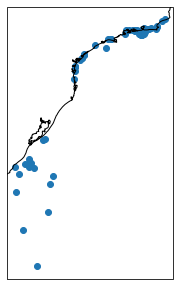

In [13]:
fig = plt.figure(figsize=(5,5))
r = 0
ax = plt.axes(projection=ccrs.PlateCarree())
#lat_BA, lon_BA = river_sources[loc]
# ax.pcolormesh(smoc['longitude'][indices['lon']], 
#               smoc['latitude'][indices['lat']],
#               land_mask)
#ax.set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())

ax.coastlines()
t = 370
ax.scatter(particles['lon'][:,t], particles['lat'][:,t]);

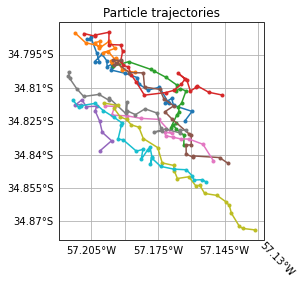

<module 'matplotlib.pyplot' from '/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [255]:
%matplotlib inline

plotTrajectoriesFile('../data/simulations/model_setup_test2.nc', mode='2d')